Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
epoch: 0  validation loss: 0.33498642
epoch: 1  validation loss: 0.24694246
epoch: 2  validation loss: 0.16259626
epoch: 3  validation loss: 0.07966284
epoch: 4  validation loss: 0.045796722
epoch: 5  validation loss: 0.030247573
epoch: 6  validation loss: 0.02692272
epoch: 7  validation loss: 0.011568797
epoch: 8  validation loss: 0.009993709
epoch: 9  validation loss: 0.0066816714
epoch: 10  validation loss: 0.014300262
epoch: 11  validation loss: 0.00699237
epoch: 12  validation loss: 0.0058282176
epoch: 13  validation loss: 0.0035185267
epoch: 14  validation loss: 0.0019434935
epoch: 15  validation loss: 0.0013511016
epoch: 16  validation loss: 0.0013287794
epoch: 17  validation loss: 0.0018342505
epoch: 18  validation loss: 0.0017795342
epoch: 19  validation loss: 0.002291315
epoch: 

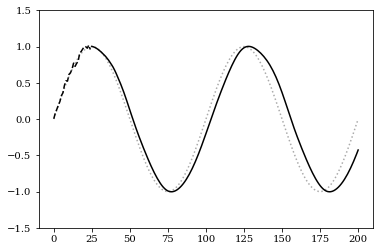

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(0)
tf.set_random_seed(1234)


def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)

    cell = tf.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0)
    initial_state = cell.zero_state(n_batch, tf.float32)

    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.variable_scope('LSTM'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)

    output = outputs[-1]

    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性

    return y


def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse


def training(loss):
    optimizer = \
        tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)

    train_step = optimizer.minimize(loss)
    return train_step


class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False


if __name__ == '__main__':
    def sin(x, T=100):
        return np.sin(2.0 * np.pi * x / T)

    def toy_problem(T=100, ampl=0.05):
        x = np.arange(0, 2 * T + 1)
        noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
        return sin(x) + noise

    '''
    データの生成
    '''
    T = 100
    f = toy_problem(T)

    length_of_sequences = 2 * T
    maxlen = 25

    data = []
    target = []

    for i in range(0, length_of_sequences - maxlen + 1):
        data.append(f[i: i + maxlen])
        target.append(f[i + maxlen])

    X = np.array(data).reshape(len(data), maxlen, 1)
    Y = np.array(target).reshape(len(data), 1)

    # データ設定
    N_train = int(len(data) * 0.9)
    N_validation = len(data) - N_train

    X_train, X_validation, Y_train, Y_validation = \
        train_test_split(X, Y, test_size=N_validation)

    '''
    モデル設定
    '''
    n_in = len(X[0][0])  # 1
    n_hidden = 30
    n_out = len(Y[0])  # 1

    x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
    t = tf.placeholder(tf.float32, shape=[None, n_out])
    n_batch = tf.placeholder(tf.int32, shape=[])

    y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
    loss = loss(y, t)
    train_step = training(loss)

    early_stopping = EarlyStopping(patience=10, verbose=1)
    history = {
        'val_loss': []
    }

    '''
    モデル学習
    '''
    epochs = 500
    batch_size = 10

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    n_batches = N_train // batch_size

    for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
            })

        # 検証データを用いた評価
        val_loss = loss.eval(session=sess, feed_dict={
            x: X_validation,
            t: Y_validation,
            n_batch: N_validation
        })

        history['val_loss'].append(val_loss)
        print('epoch:', epoch,
              ' validation loss:', val_loss)

        # Early Stopping チェック
        if early_stopping.validate(val_loss):
            break

    '''
    出力を用いて予測
    '''
    truncate = maxlen
    Z = X[:1]  # 元データの最初の一部だけ切り出し

    original = [f[i] for i in range(maxlen)]
    predicted = [None for i in range(maxlen)]

    for i in range(length_of_sequences - maxlen + 1):
        # 最後の時系列データから未来を予測
        z_ = Z[-1:]
        y_ = y.eval(session=sess, feed_dict={
            x: Z[-1:],
            n_batch: 1
        })
        # 予測結果を用いて新しい時系列データを生成
        sequence_ = np.concatenate(
            (z_.reshape(maxlen, n_in)[1:], y_), axis=0) \
            .reshape(1, maxlen, n_in)
        Z = np.append(Z, sequence_, axis=0)
        predicted.append(y_.reshape(-1))

    '''
    グラフで可視化
    '''
    plt.rc('font', family='serif')
    plt.figure()
    plt.ylim([-1.5, 1.5])
    plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(predicted, color='black')
    plt.show()